In [2]:
import os
import os.path
os.environ["TF_USE_LEGACY_KERAS"] = "1"

In [3]:
import joblib
import requests
from io import StringIO

In [4]:
import numpy as np
import pandas as pd

In [5]:
#!pip install -q seaborn

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [8]:
import tensorflow as tf
np.random.seed(0)
tf.random.set_seed(0)

FROM_SCRATCH = False
TF_MODEL_FNAME = 'tf-clf-wine'
RFC_FNAME = 'rfc-wine'
ENC_FNAME = 'wine_encoder'
DEC_FNAME = 'wine_decoder'

2025-05-12 04:59:39.603642: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-12 04:59:39.606985: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-12 04:59:39.657817: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-12 04:59:39.657869: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-12 04:59:39.657931: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [9]:
def fetch_wine_ds():
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
    resp = requests.get(url, timeout=2)
    resp.raise_for_status()
    string_io = StringIO(resp.content.decode('utf-8'))
    return pd.read_csv(string_io, sep=';')

In [10]:
df = fetch_wine_ds()

In [11]:
df['class'] = 'bad'
df.loc[(df['quality'] > 5), 'class'] = 'good'

features = [
    'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
    'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
    'pH', 'sulphates', 'alcohol'
]

df['good'] = 0
df['bad'] = 0
df.loc[df['class'] == 'good', 'good'] = 1
df.loc[df['class'] == 'bad', 'bad'] = 1

data = df[features].to_numpy()
labels = df[['class','good', 'bad']].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state=0)
X_train, X_test = X_train.astype('float32'), X_test.astype('float32')
y_train_lab, y_test_lab = y_train[:, 0], y_test[:, 0]
y_train, y_test = y_train[:, 1:].astype('float32'), y_test[:, 1:].astype('float32')

scaler = StandardScaler()

In [12]:
scaler.fit(X_train)

StandardScaler()

In [13]:
bad_wines = np.array([a for a, b in zip(X_train, y_train) if b[1] == 1])
good_wines = np.array([a for a, b in zip(X_train, y_train) if b[1] == 0])
x = np.array([[9.2, 0.36, 0.34, 1.6, 0.062, 5., 12., 0.99667, 3.2, 0.67, 10.5]]) # prechosen instance

In [14]:
from tensorflow.keras.layers import Dense
from tensorflow import keras


ENCODING_DIM = 7
BATCH_SIZE = 64
EPOCHS = 100


class AE(keras.Model):
    def __init__(self, encoder: keras.Model, decoder: keras.Model, **kwargs) -> None:
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, x: tf.Tensor, **kwargs):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

def make_ae():
    len_input_output = X_train.shape[-1]

    encoder = keras.Sequential()
    encoder.add(Dense(units=ENCODING_DIM*2, activation="relu", input_shape=(len_input_output, )))
    encoder.add(Dense(units=ENCODING_DIM, activation="relu"))

    decoder = keras.Sequential()
    decoder.add(Dense(units=ENCODING_DIM*2, activation="relu", input_shape=(ENCODING_DIM, )))
    decoder.add(Dense(units=len_input_output, activation="linear"))

    ae = AE(encoder=encoder, decoder=decoder)

    ae.compile(optimizer='adam', loss='mean_squared_error')
    history = ae.fit(
        scaler.transform(X_train),
        scaler.transform(X_train),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        verbose=False,)

    # loss = history.history['loss']
    # plt.plot(loss)
    # plt.xlabel('Epoch')
    # plt.ylabel('MSE-Loss')

    ae.encoder.save(f'{ENC_FNAME}.h5')
    ae.decoder.save(f'{DEC_FNAME}.h5')
    return ae

def load_ae_model():
    encoder = load_model(f'{ENC_FNAME}.h5')
    decoder = load_model(f'{DEC_FNAME}.h5')
    return AE(encoder=encoder, decoder=decoder)

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score


def make_rfc():
    rfc = RandomForestClassifier(n_estimators=50)
    rfc.fit(scaler.transform(X_train), y_train_lab)
    y_pred = rfc.predict(scaler.transform(X_test))

    print('accuracy_score:', accuracy_score(y_pred, y_test_lab))
    print('f1_score:', f1_score(y_test_lab, y_pred, average=None))

    joblib.dump(rfc, f"{RFC_FNAME}.joblib")
    return rfc


def load_rfc_model():
    return joblib.load(f"{RFC_FNAME}.joblib")

In [16]:
from tensorflow import keras
from tensorflow.keras import layers

def make_tf_model():
    inputs = keras.Input(shape=X_train.shape[1])
    x = layers.Dense(6, activation="relu")(inputs)
    outputs = layers.Dense(2, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
    history = model.fit(
        scaler.transform(X_train),
        y_train,
        epochs=30,
        verbose=False,
        validation_data=(scaler.transform(X_test), y_test),
    )

    y_pred = model(scaler.transform(X_test)).numpy().argmax(axis=1)
    print('accuracy_score:', accuracy_score(y_pred, y_test.argmax(axis=1)))
    print('f1_score:', f1_score(y_pred, y_test.argmax(axis=1), average=None))

    model.save(f'{TF_MODEL_FNAME}.h5')
    return model

def load_tf_model():
    return load_model(f'{TF_MODEL_FNAME}.h5')

In [18]:
if FROM_SCRATCH or not os.path.isfile(f'{TF_MODEL_FNAME}.h5'):
    model = make_tf_model()
    rfc = make_rfc()
    ae = make_ae()
else:
    rfc = load_rfc_model()
    model = load_tf_model()
    ae = load_ae_model()

accuracy_score: 0.725
f1_score: [0.74418605 0.7027027 ]
accuracy_score: 0.815
f1_score: [0.8        0.82790698]


/home/pajaro/anaconda3/envs/ali_env_v1/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


/home/pajaro/anaconda3/envs/ali_env_v1/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
def compare_instances(x, cf):
    
    x = x.astype('float64')
    cf = cf.astype('float64')
    for f, v1, v2 in zip(features, x[0], cf[0]):
        print(f'{f:<25} instance: {round(v1, 3):^10} counter factual: {round(v2, 3):^10} difference: {round(v1 - v2, 7):^5}')

def plot_importance(feat_imp, feat_names, class_idx, **kwargs):
    """
    Create a horizontal barchart of feature effects, sorted by their magnitude.
    """

    df = pd.DataFrame(data=feat_imp, columns=feat_names).sort_values(by=0, axis='columns')
    feat_imp, feat_names = df.values[0], df.columns
    fig, ax = plt.subplots(figsize=(10, 5))
    y_pos = np.arange(len(feat_imp))
    ax.barh(y_pos, feat_imp)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(feat_names, fontsize=15)
    ax.invert_yaxis()
    ax.set_xlabel(f'Feature effects for class {class_idx}', fontsize=15)
    return ax, fig

In [29]:
 y_pos = np.arange(len(result.data['attributions'][0]))
 print(y_pos.shape)
 print(len(y_pos))

(1,)
1


In [20]:
x_scaler = scaler.transform(x)
print('x:', x_scaler)

x: [[ 0.4965967  -0.92901276  0.35459386 -0.64843646 -0.52430681 -1.04907196
  -1.04084214 -0.04649272 -0.70585213  0.0635862   0.08832099]]


/home/pajaro/anaconda3/envs/ali_env_v1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-12 05:04:06,383	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


(<Axes: xlabel='Feature effects for class "good"'>,
 <Figure size 1000x500 with 1 Axes>)

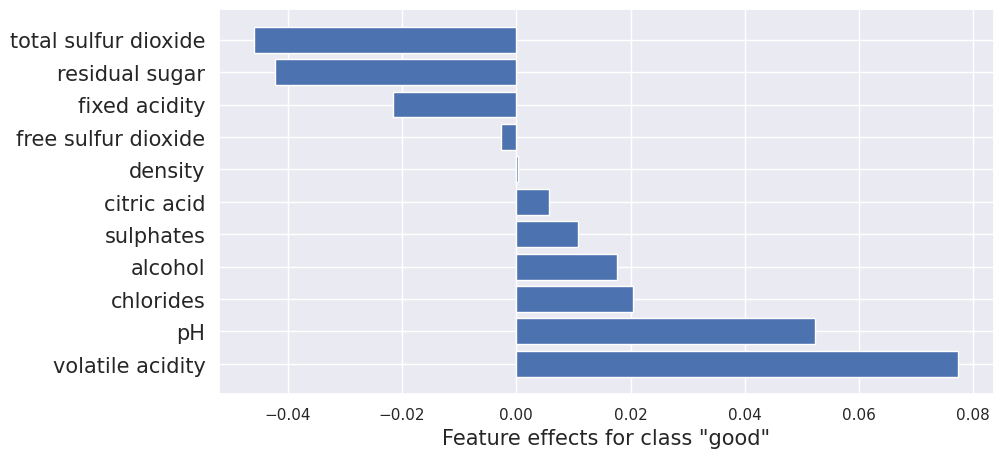

In [22]:
from alibi.explainers import IntegratedGradients

ig = IntegratedGradients(model,
                         layer=None,
                         method="gausslegendre",
                         n_steps=50,
                         internal_batch_size=100)

result = ig.explain(scaler.transform(x), target=0)

plot_importance(result.data['attributions'][0], features, '"good"')

In [23]:
print(type(result))

<class 'alibi.api.interfaces.Explanation'>


In [24]:
print(result.__dict__.keys())

dict_keys(['meta', 'data', 'attributions', 'X', 'forward_kwargs', 'baselines', 'predictions', 'deltas', 'target', 'name', 'type', 'explanations', 'params', 'version'])


In [26]:
print(type(result.data['attributions'][0]))
print(result.data['attributions'][0].shape)

<class 'numpy.ndarray'>
(1, 11)


In [27]:
print(result.data['attributions'][0])

[[-0.02153269  0.07742667  0.00569748 -0.04223303  0.02042485 -0.00273784
  -0.04594203  0.00027737  0.05225258  0.01075884  0.01763241]]


In [ ]:
df = pd.DataFrame(data=feat_imp, columns=feat_names).sort_values(by=0, axis='columns')